In [62]:
import pandas as pd

train_data = pd.read_csv('cure_the_princess_train.csv')
val_data = pd.read_csv('cure_the_princess_validation.csv')
test_data = pd.read_csv('cure_the_princess_test.csv')

In [63]:
import numpy as np

train_data_np = train_data.to_numpy()
val_data_np = val_data.to_numpy()
test_data_np = test_data.to_numpy()


In [64]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_inputs = torch.from_numpy(train_data_np[:, :13]).float().to(device)
train_labels = torch.from_numpy(train_data_np[:, 13]).long().to(device)

val_inputs = torch.from_numpy(val_data_np[:, :13]).float().to(device)
val_labels = torch.from_numpy(val_data_np[:, 13]).long().to(device)

test_inputs = torch.from_numpy(test_data_np[:, :13]).float().to(device)
test_labels = torch.from_numpy(test_data_np[:, 13]).long().to(device)


cuda:0


In [65]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [66]:
import torch.nn as nn

torch.manual_seed(190401055)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 100)
        self.hidden_layer_2 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [67]:
train_losses = []
val_losses = []
num_epochs = 2000
patience = 100
best_val_loss = np.inf
patience_counter = 0
best_model = None

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch + 1} epochs')
                break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Patience: {patience_counter}')

torch.save(best_model, 'best_model.pt')



Epoch 1/2000, Train Loss: 0.7125, Val Loss: 0.6848, Patience: 0
Epoch 2/2000, Train Loss: 0.6782, Val Loss: 0.6667, Patience: 0
Epoch 3/2000, Train Loss: 0.6599, Val Loss: 0.6516, Patience: 0
Epoch 4/2000, Train Loss: 0.6469, Val Loss: 0.6402, Patience: 0
Epoch 5/2000, Train Loss: 0.6337, Val Loss: 0.6284, Patience: 0
Epoch 6/2000, Train Loss: 0.6235, Val Loss: 0.6178, Patience: 0
Epoch 7/2000, Train Loss: 0.6144, Val Loss: 0.6090, Patience: 0
Epoch 8/2000, Train Loss: 0.6058, Val Loss: 0.6002, Patience: 0
Epoch 9/2000, Train Loss: 0.5963, Val Loss: 0.5959, Patience: 0
Epoch 10/2000, Train Loss: 0.5906, Val Loss: 0.5824, Patience: 0
Epoch 11/2000, Train Loss: 0.5815, Val Loss: 0.5737, Patience: 0
Epoch 12/2000, Train Loss: 0.5745, Val Loss: 0.5659, Patience: 0
Epoch 13/2000, Train Loss: 0.5676, Val Loss: 0.5594, Patience: 0
Epoch 14/2000, Train Loss: 0.5605, Val Loss: 0.5520, Patience: 0
Epoch 15/2000, Train Loss: 0.5524, Val Loss: 0.5479, Patience: 0
Epoch 16/2000, Train Loss: 0.5470,

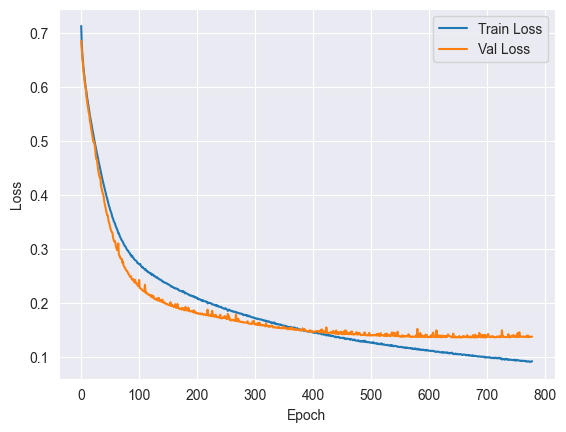

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
